# Preamble
## Setup of environment

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

In [ ]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [ ]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Cardiac Project/Registration_phase/voxelMorph/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Registration_phase/voxelMorph


In [ ]:
import glob
import imageio

### load cine images for training dataset
cine_train = []
i = 0
print("cine_train: ", end="")
for image_path in glob.glob("./cine_images/*.png"):
    image = imageio.imread(image_path)
    cine_train.append(image)
    i += 1
    if i == int(image_path.split('/')[-1].split('_')[0]):
      print(i, end=" ")
    else:
      print("Error")
      break
cine_train = np.array(cine_train)

### load lge images for training dataset
lge_train = []
i = 0
print()
print("lge_train: ", end="")
for image_path in glob.glob("./lge_images/*.png"):
    image = imageio.imread(image_path)
    lge_train.append(image)
    i += 1
    if i == int(image_path.split('/')[-1].split('_')[0]):
      print(i, end=" ")
    else:
      print("Error")
      break
lge_train = np.array(lge_train)

cine_train: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 
lge_train: 1 2 3 4 5 6 7 8 9 10

In [ ]:
# let's get some shapes to understand what we loaded.
print('shape of cine_train: {}, lge_train: {}'.format(cine_train.shape, lge_train.shape))

shape of cine_train: (266, 64, 64), lge_train: (266, 64, 64)


### Visualize Data

In [1]:
idx = np.random.choice(cine_train.shape[0], 5, replace=False)
cine_examples = [f for f in cine_train[idx, ...]]
lge_examples = [f for f in lge_train[idx, ...]]

# plot
ne.plot.slices(cine_examples, cmaps=['gray'], do_colorbars=True);
ne.plot.slices(lge_examples, cmaps=['gray'], do_colorbars=True);

NameError: ignored

Luckily we included a **colorbar**, which shows us that the data is in [0, 255].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
Let's fix this. 

In general, you should always plot your data with colorbars, which helps you catch issues before training  

In [ ]:
# fix data
cine_train = cine_train.astype('float')/255
lge_train = lge_train.astype('float')/255

In [ ]:
# verify
print('cine_train maximum value', cine_train.max())
print('lge_train maximum value', lge_train.max())

cine_train maximum value 1.0
lge_train maximum value 1.0


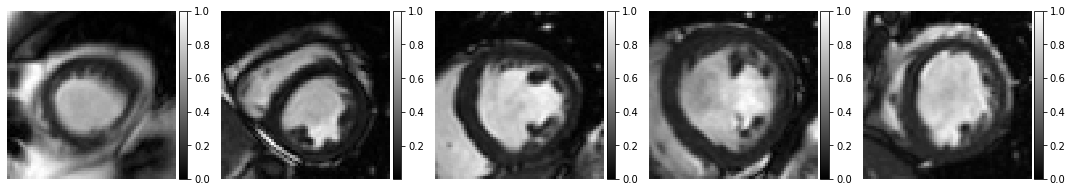

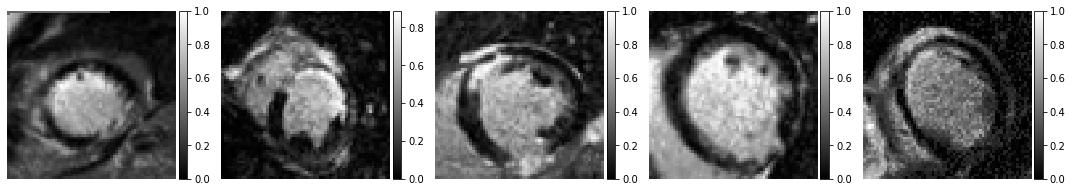

In [ ]:
# re-visualize
cine_examples = [f for f in cine_train[idx, ...]]
lge_examples = [f for f in lge_train[idx, ...]]

# plot
ne.plot.slices(cine_examples, cmaps=['gray'], do_colorbars=True);
ne.plot.slices(lge_examples, cmaps=['gray'], do_colorbars=True);

Later on, we'll see that some of the most popular models like to have inputs that are sized as multiples of 2^N for N being the number of layers. Here, our images are in size 64 (4x 2^4).

In [ ]:
# verify
print('shape of training data', cine_train.shape)
print('shape of training data', lge_train.shape)

shape of training data (266, 64, 64)
shape of training data (266, 64, 64)


---

# CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") (e.g. MNIST digits of size 32x32) and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to moving the moving image to match up with the fixed image. 

**Note**: Registration also includes (or refers to) affine transforms, but we ignore that here.

The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. We will discuss this class later on, but for tutorial sake, we'll start by building this model from scratch in order to demonstrate the individual components of the network. First, we're going to abstract the UNet and with the `vxm.networks.Unet()` model.

In [ ]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*cine_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

In [ ]:
inshape

(64, 64, 2)

Let's explore the model bit...

In [ ]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 64, 64, 2)
output shape: (None, 64, 64, 16)


Now we need to make sure the final output has 2 features, representing the deformation at each voxel.

In [ ]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 64, 64, 2)


The deformation model `def_model` will now *share layers* with the UNet model, so if we change layer weights in `unet`, they change in `def_model`.

### Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$. To do this, we use a spatial transformation network layer, which essentially does linear interpolation.

In [ ]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

Instructions for updating:
Use fn_output_signature instead


To make sure the moved image is close to the fixed image, and to achieve smoothness loss of $\phi$ in (2), we will want these two as outputs from the full model.

In [ ]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

The model we just created represents the standard, dense VoxelMorph archetecture, with a UNet component, displacement field, and final spatial transformer layer. However, you don't have to build this model from scratch every time - the VoxelMorph library provides a highly customizable `VxmDense` model class that encompasses this archetecture.

From now on in the tutorial, we will be using `VxmDense` class to build models, so let's rebuild the equivolent network.

In [ ]:
# build model using VxmDense
inshape = cine_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced tutorial.

It's worth noting that the `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

Let's take one final look at the model.

In [ ]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 64, 64, 1), (None, 64, 64, 1)
output shape: (None, 64, 64, 1), (None, 64, 64, 2)


Now that've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss for each output.    
The first loss is easy, it's simply MSE between the warped image $m \circ \phi$.
For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

In [ ]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.01
loss_weights = [1, lambda_param]

Finally, we can compile the model. 
This sets up the model for training, by associating the model with a loss and an optimizer

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

# Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it keras models can be trained with `model.fit`, which requires all the data to be in a big array, or `model.fit_generator`, which requires a python generator that gives you batches of data.

Let's code a simple data generator based on the MNIST data.

In [ ]:
def vxm_data_generator(cine_data, lge_data, batch_size=32, indx=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = cine_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, cine_data.shape[0], size=batch_size)
        if len(indx) > 0:
          idx = indx
        moving_images = lge_data[idx, ..., np.newaxis]
        fixed_images = cine_data[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

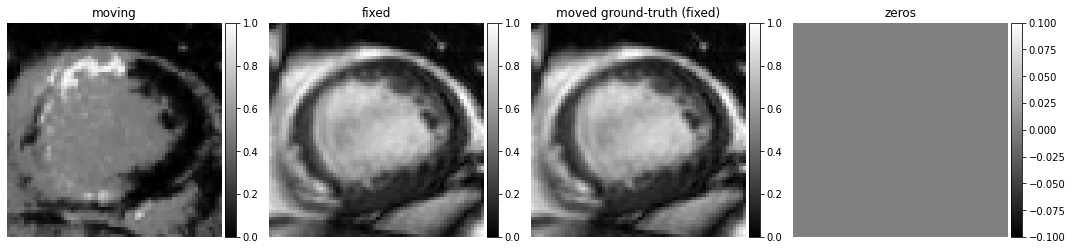

In [ ]:
# let's test it
train_generator = vxm_data_generator(cine_train, lge_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=20, steps_per_epoch=100, verbose=2);

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 8s - loss: 0.0567 - transformer_loss: 0.0567 - flow_loss: 5.0667e-04
Epoch 2/20
100/100 - 3s - loss: 0.0498 - transformer_loss: 0.0496 - flow_loss: 0.0266
Epoch 3/20
100/100 - 3s - loss: 0.0437 - transformer_loss: 0.0428 - flow_loss: 0.0864
Epoch 4/20
100/100 - 3s - loss: 0.0412 - transformer_loss: 0.0401 - flow_loss: 0.1106
Epoch 5/20
100/100 - 3s - loss: 0.0371 - transformer_loss: 0.0358 - flow_loss: 0.1337
Epoch 6/20
100/100 - 3s - loss: 0.0357 - transformer_loss: 0.0342 - flow_loss: 0.1502
Epoch 7/20
100/100 - 3s - loss: 0.0337 - transformer_loss: 0.0321 - flow_loss: 0.1611
Epoch 8/20
100/100 - 3s - loss: 0.0325 - transformer_loss: 0.0308 - flow_loss: 0.1682
Epoch 9/20
100/100 - 3s - loss: 0.0319 - transformer_loss: 0.0300 - flow_loss: 0.1872
Epoch 10/20
100/100 - 3s - loss: 0.0308 - transformer_loss: 0.0289 - flow_loss: 0.1986
Epoch 11/20
100/100 - 3s - loss: 0.0303 - transformer_loss: 0.0283 - flow_loss: 0.2017
Epoch 12/20
100/100 - 3s - loss: 0.0306 - transf

It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard.

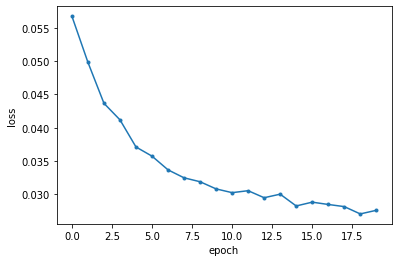

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Registration

With pair-wise optimization methods (like most classical methods), to register a new pair you would need to optimize a deformation field.  

With learning based registration, we simply evaluate the network for a new input pair  

[62, 130, 12, 61, 116, 71]


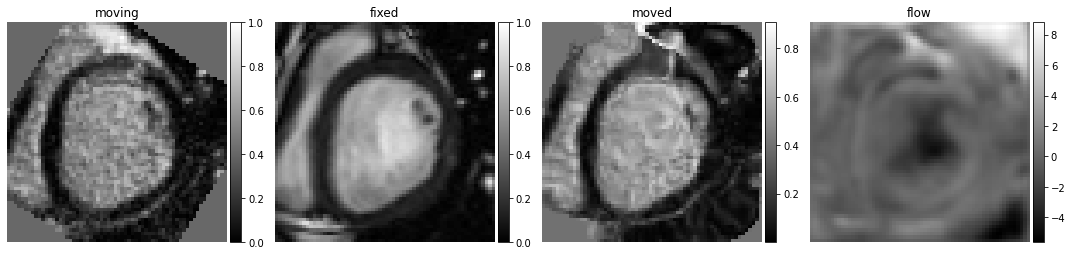

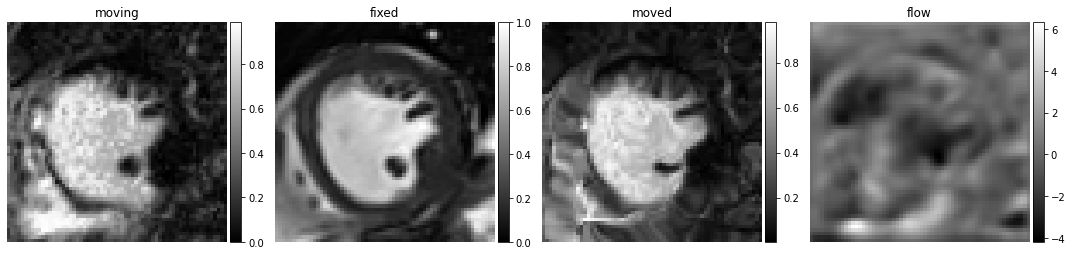

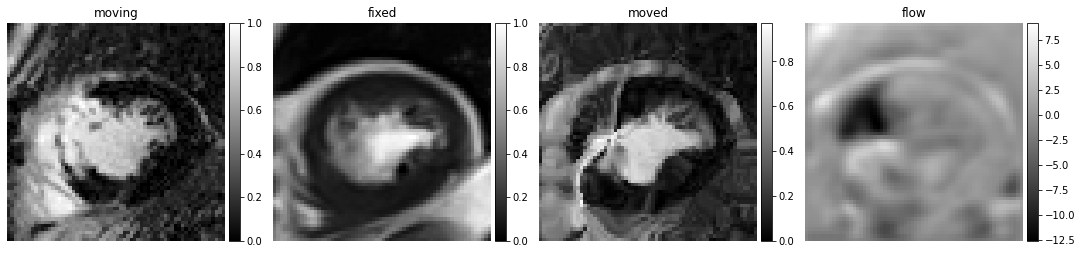

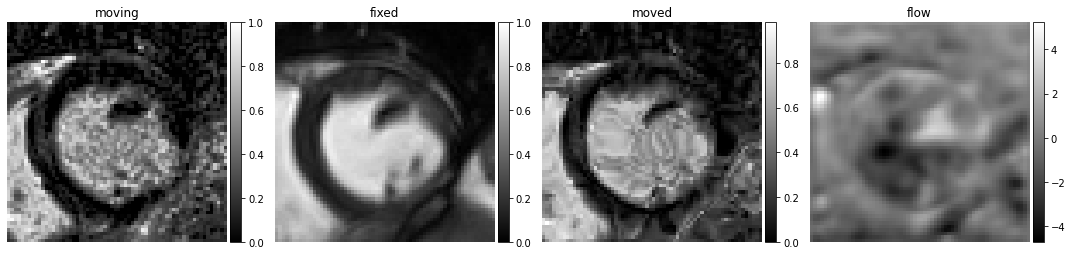

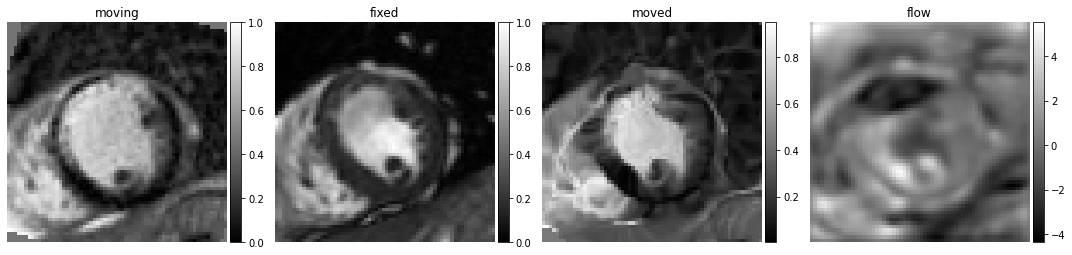

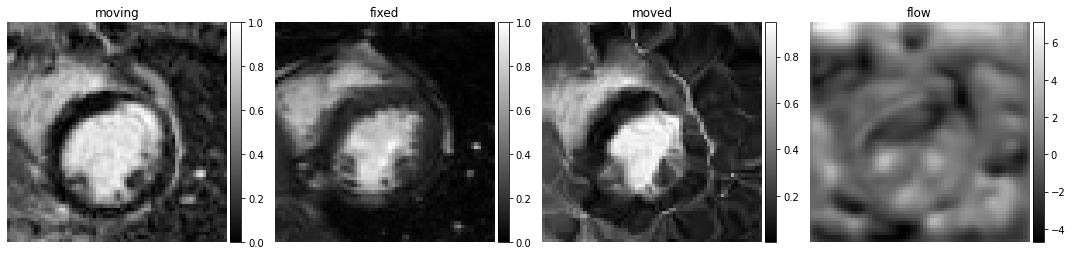

In [ ]:
# let's see some results
indx = np.random.randint(0, cine_train.shape[0], size=5)
# good: [62, 130, 12, 61, 116, 71]
indx = [62, 130, 12, 61, 116, 71]
# bad: [241, 259]
print(indx)
for i in indx:
    # get some data
    val_generator = vxm_data_generator(cine_train, lge_train, batch_size = 1, indx=[i])
    val_input, _ = next(val_generator)
    val_pred = vxm_model.predict(val_input)


    # visualize
    images = [img[0, :, :, 0] for img in val_input + val_pred] 
    titles = ['moving', 'fixed', 'moved', 'flow']
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Let's visualize the flow a bit better.

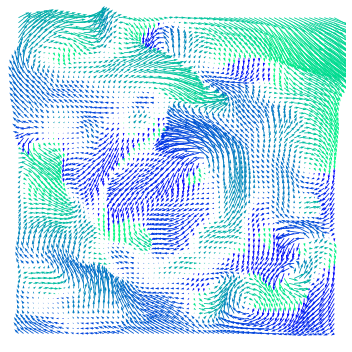

In [ ]:
ne.plot.flow([val_pred[1].squeeze()], width=5);

# Transfer Learning

Let's use the pre-trained model on brain MRIs to register the cardiac images.

We initial our vxm_model with brain_2d_smooth.h5 and run it for several epochs on cardiac data.

Note that in this case, U-net architecture of vxm_model should be the same as the model used for brain MRI registration.

In [ ]:
vxm_model_transfered = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
vxm_model_transfered.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
vxm_model_transfered.load_weights('brain_2d_smooth.h5')

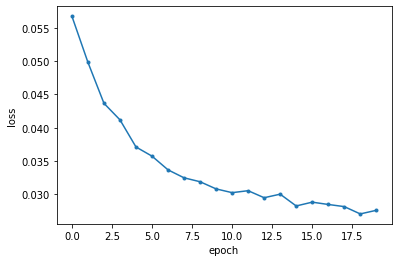

In [ ]:
plot_history(hist)

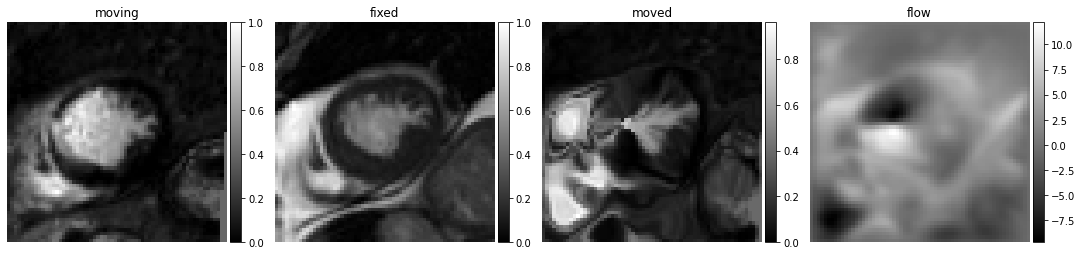

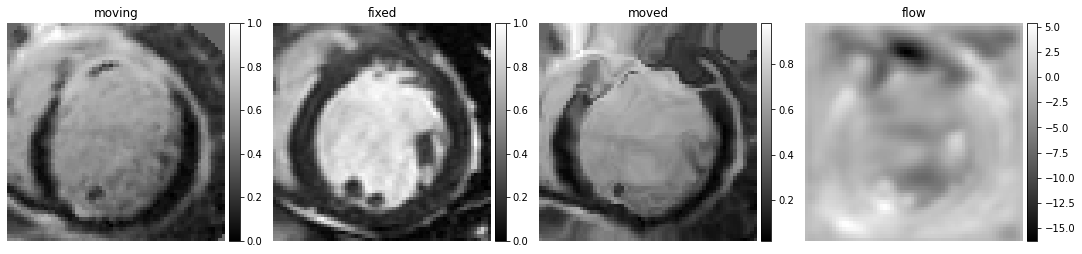

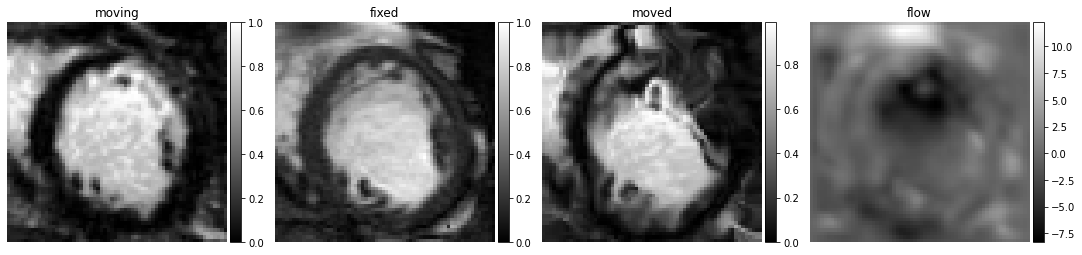

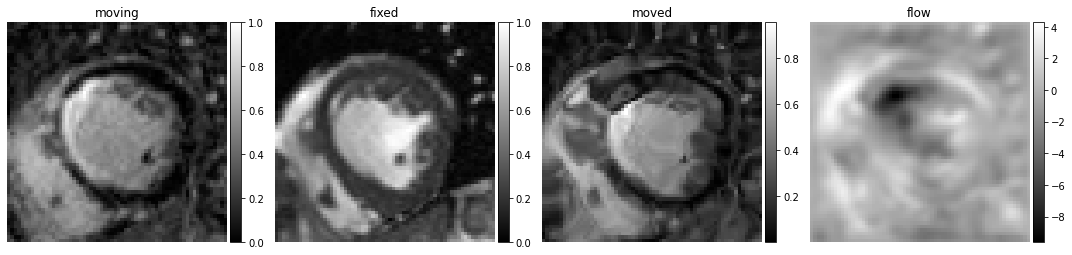

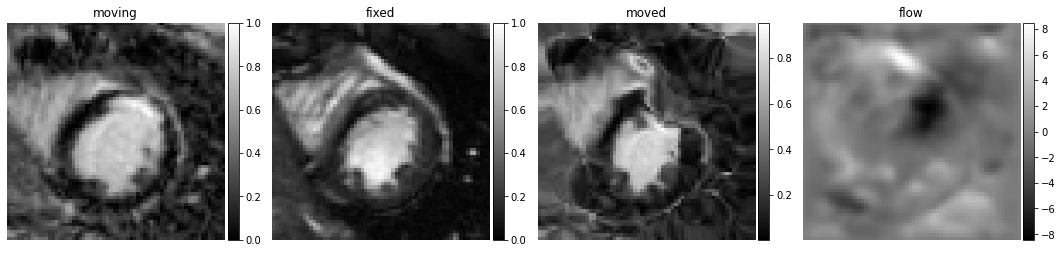

In [ ]:
# let's see more results
for i in indx:
    # get some data
    val_generator = vxm_data_generator(cine_train, lge_train, batch_size = 1, indx=[i])
    val_input, _ = next(val_generator)
    val_pred = vxm_model_transfered.predict(val_input)


    # visualize
    images = [img[0, :, :, 0] for img in val_input + val_pred] 
    titles = ['moving', 'fixed', 'moved', 'flow']
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# Registration of Brain MRI

We will now register MRIs of the brain.  To be able to train and easily register during this tutorial, we will first extract the middle slice of brain scans.

Note that because this task does not capture deformations in the third dimensions, certain  correspondances are not exactly possible.  Nonetheless, this exercise will illustrate registration with more realistic complex images.   

The brains have been intensity-normalized, affinely aligned, and skull-stripped with FreeSurfer, to enable focusing on deformable registration.

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2021-04-14 13:53:23--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16643404 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  14.1MB/s    in 1.1s    

2021-04-14 13:53:25 (14.1 MB/s) - ‘data.tar.gz’ saved [16643404/16643404]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


Let's take a look at some of the data.

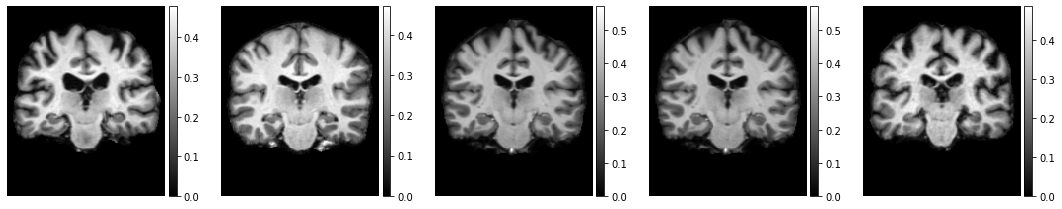

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

### Model


As with cardiac dataset, let's create a standard VoxelMorph model trained with MSE and spatial smoothing losses.

In [ ]:
# unet
nb_features_brain = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]
vxm_model_brain = vxm.networks.VxmDense(vol_shape, nb_features_brain, int_steps=0)

# losses and loss weights
losses_brain = ['mse', vxm.losses.Grad('l2').loss]
loss_weights_brain = [1, 0.01]

From experimentation, we have found the Adam optimizer learning rate of `1e-4` performs better than `1e-3` for this problem.

In [ ]:
vxm_model_brain.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses_brain, loss_weights=loss_weights_brain)

In [ ]:
def vxm_data_generator_brain(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

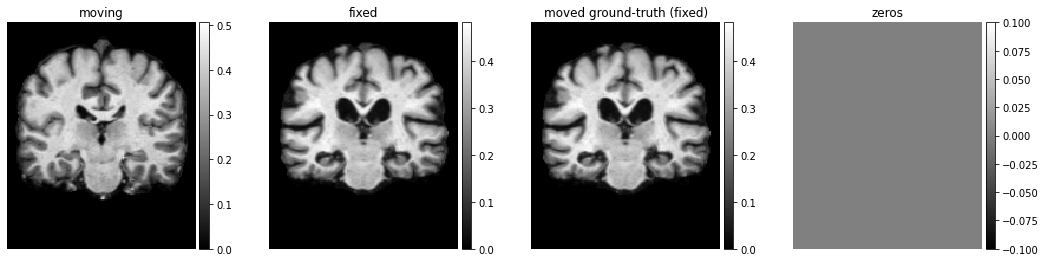

In [ ]:
# let's test it
train_generator_brain = vxm_data_generator_brain(x_train, batch_size=8)
in_sample, out_sample = next(train_generator_brain)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**

In [ ]:
hist = vxm_model_brain.fit_generator(train_generator_brain, epochs=1, steps_per_epoch=100, verbose=2);

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 - 13s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 5.3080e-05


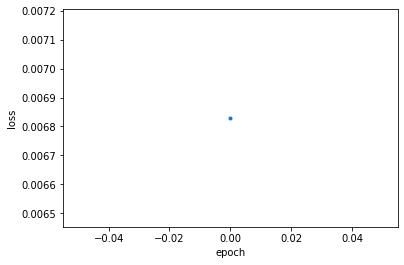

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

Let's load a model pretrained for 200 epochs:

In [ ]:
# load pretrained model weights
vxm_model_brain.load_weights('brain_2d_smooth.h5')

Now let's see some results using validation data...

In [ ]:
# create the validation data generator
val_generator_brain = vxm_data_generator_brain(x_val, batch_size = 1)
val_input, _ = next(val_generator_brain)

In [ ]:
# prediction
val_pred = vxm_model_brain.predict(val_input)

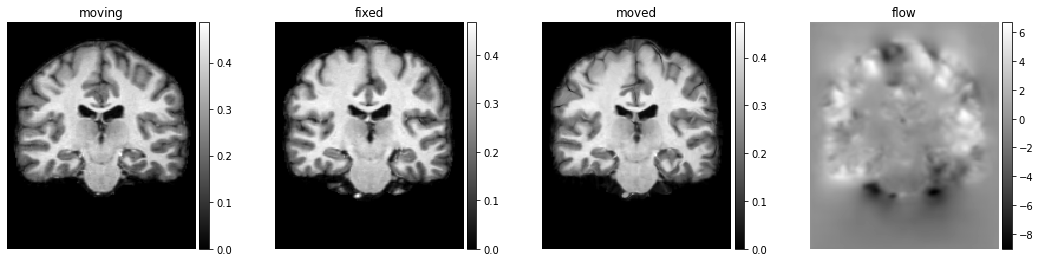

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

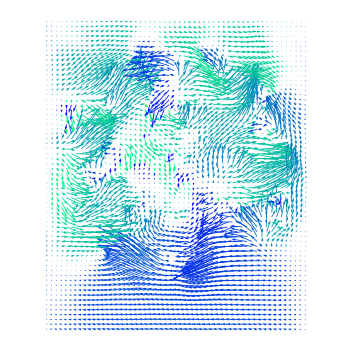

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [ ]:
# prediction from model with MSE + smoothness loss
vxm_model_brain.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model_brain.predict(val_input)

# prediction from model with just MSE loss
vxm_model_brain.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model_brain.predict(val_input)

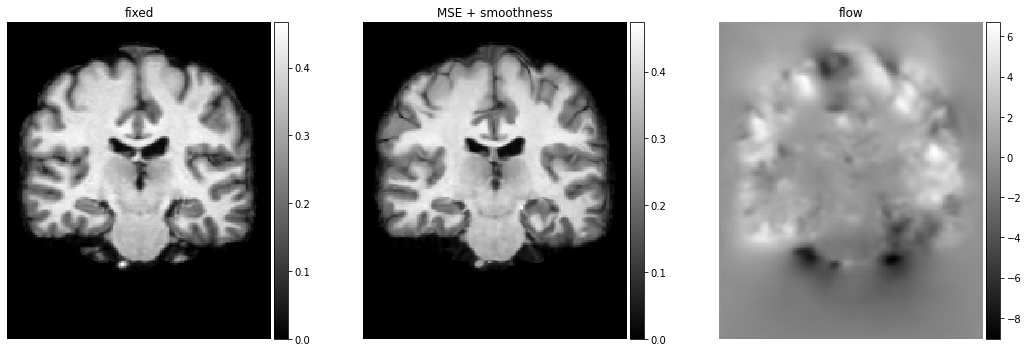

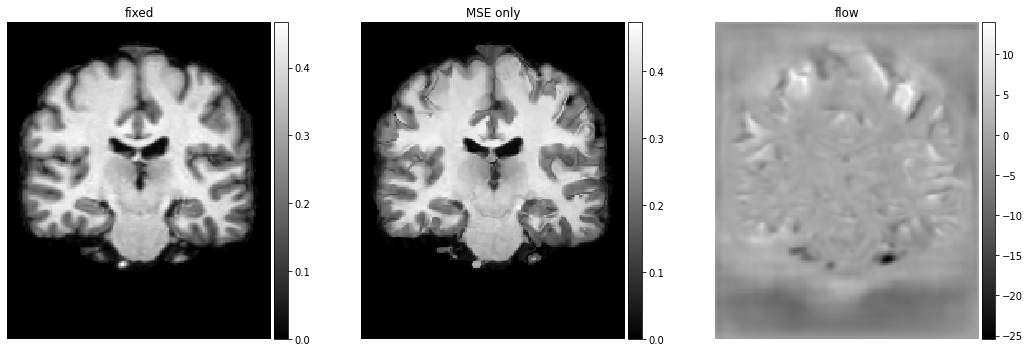

In [ ]:
# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

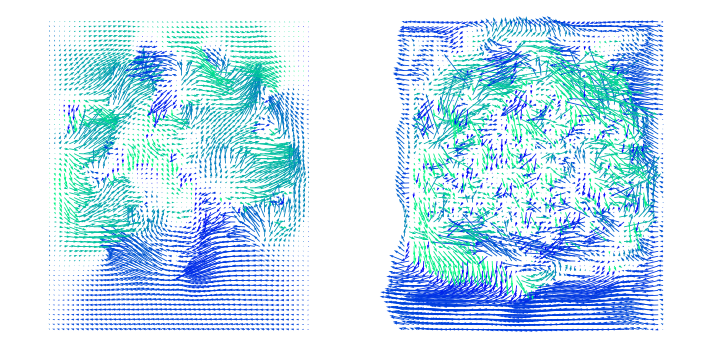

In [ ]:
ne.plot.flow([img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]], width=10);

At first look, the MSE-only model matches the fixed image better, but we can see that it obtains a deformation field that is very noisy, unlikely to be anatomically meaningful.